# Code Search Engine with Fine-tuning on CosQA Dataset

## Solution Report

This notebook demonstrates a complete implementation of an embeddings-based code search engine, including:
1. **Part 1**: Search engine implementation with FAISS
2. **Part 2**: Evaluation on CosQA dataset (Recall@10, MRR@10, NDCG@10)
3. **Part 3**: Fine-tuning with Multiple Negatives Ranking Loss (MNRL)

---

## Setup and Imports

In [1]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from search_engine import SearchEngine
from evaluation import get_metrics
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available() if hasattr(torch.backends, 'mps') else False}")

/Users/max0072/Desktop/fine_tunning_on_CosQA_dataset/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 2.8.0
CUDA available: False
MPS available: True


---
## Part 1: Embeddings-Based Search Engine

### Architecture Overview

The search engine consists of:
- **Model**: `all-MiniLM-L6-v2` sentence transformer (384-dimensional embeddings)
- **Vector Store**: FAISS `IndexFlatIP` (Inner Product for cosine similarity)
- **Normalization**: All embeddings are L2-normalized for cosine similarity
- **Features**: Batch search, ID mapping, JSON/JSONL support

### Demo: Search Engine on Test Data

In [3]:
# Load base model
base_model = SentenceTransformer("all-MiniLM-L6-v2")
engine = SearchEngine(model=base_model)

# Load test data (cities information)
import json
with open("test_data_for_api/test_data1.json", "r") as f:
    test_documents = json.load(f)

print(f"Loaded {len(test_documents)} documents")

Loaded 50 documents


In [4]:
# Upload documents to the search engine
engine.upload_data(test_documents)
print(f"Total vectors in index: {engine.index.ntotal}")

Data uploaded to engine.
Total vectors in index: 50


In [7]:
# Test queries
with open("test_data_for_api/test_query1.jsonl", "r", encoding="utf-8") as f:
    test_queries = [json.loads(line) for line in f if line.strip()]

print("Search Results Demo:")
print("="*60)
for query in test_queries:
    results = engine.find_similar_from_text(query["text"], k=3)
    print(f"Query: {query["text"]}")
    print(f"Top 3 Results:")
    for idx, (doc_id, score) in enumerate(zip(results["ids"], results["scores"]), 1):
        doc = engine.int_id_to_data[doc_id]
        print(f"  {idx}. [{score:.4f}] {doc.title}: {doc.text}")
    print("-"*60)

Search Results Demo:
Query: What is the best season to visit Paris?
Top 3 Results:
  1. [0.8134] Paris: Best time to visit Paris is spring
  2. [0.3791] Montreal: Montreal is known for French culture
  3. [0.2688] Los Angeles: Hollywood is located in LA
------------------------------------------------------------
Query: Which city is the capital of Poland?
Top 3 Results:
  1. [0.8656] Warsaw: Warsaw is the capital of Poland
  2. [0.5392] Helsinki: Helsinki is the capital of Finland
  3. [0.5069] Tehran: Capital of Iran
------------------------------------------------------------
Query: Name a city famous for tango
Top 3 Results:
  1. [0.8068] Buenos Aires: Famous for tango
  2. [0.3458] Berlin: Berlin is famous for its history and culture
  3. [0.3449] Mexico City: Largest city in Latin America
------------------------------------------------------------
Query: Where is the Golden Gate Bridge located?
Top 3 Results:
  1. [0.5873] San Francisco: Golden Gate Br_idge is the symbol of SF
 

---
## Part 2: Evaluation on CosQA Dataset

### Dataset Overview

**CosQA** (Code Search Question Answering) contains:
- Natural language queries
- Code samples
- Relevance annotations between queries and code

### Evaluation Metrics

We implement three standard information retrieval metrics:

1. **Recall@10**: Percentage of queries where the relevant document appears in top-10 results
   - Formula: `1/N * Σ(1 if rank_i <= 10 else 0)`
   
2. **MRR@10**: Mean Reciprocal Rank - average of reciprocal ranks of first relevant result
   - Formula: `1/N * Σ(1/rank_i if rank_i <= 10 else 0)`
   
3. **NDCG@10**: Normalized Discounted Cumulative Gain - considers position of relevant result
   - Formula: `1/N * Σ(1/log2(rank_i + 1) if rank_i <= 10 else 0)`

### Baseline Evaluation (Before Fine-tuning)

In [8]:
# Evaluate base model on CosQA test set
print("Evaluating baseline model (all-MiniLM-L6-v2)...")

base_model = SentenceTransformer("all-MiniLM-L6-v2")
base_recall, base_mrr, base_ndcg = get_metrics(base_model)

print("Baseline Results (Before Fine-tuning):")
print("="*60)
print(f"  Recall@10: {base_recall:.4f} ({base_recall*100:.2f}%)")
print(f"  MRR@10:    {base_mrr:.4f}")
print(f"  NDCG@10:   {base_ndcg:.4f}")
print("="*60)

Evaluating baseline model (all-MiniLM-L6-v2)...
This may take a few minutes...

Data uploaded to engine.
Baseline Results (Before Fine-tuning):
  Recall@10: 0.9780 (97.80%)
  MRR@10:    0.7864
  NDCG@10:   0.8341


---
## Part 3: Fine-tuning with MNRL

### Training Approach

**Loss Function: Multiple Negatives Ranking Loss (MNRL)**

MNRL is suitable for training embedding models for retrieval tasks because:

1. **In-batch negatives**: For each query-code pair in a batch, all other codes serve as negatives
   - With batch size 64, we get 63 hard negatives per query
   - Computationally efficient - no need to sample negatives separately
2. **Bidirectional loss**: We compute loss in both directions (query→code and code→query)
   - Ensures symmetric similarity space
3. **Temperature scaling**: Sharpens the similarity distribution
   - Lower temperature (0.05) makes the model more confident in predictions

**Loss Formula**:
```
logits = (Q @ C^T) / temperature
loss = CrossEntropy(logits, labels) + CrossEntropy(logits^T, labels)
```

where:
- `Q`: query embeddings (batch_size × 384)
- `C`: code embeddings (batch_size × 384)
- `labels`: diagonal indices [0, 1, 2, ..., batch_size-1]

### Hyperparameters

```python
batch_size = 64
learning_rate = 1.5e-5
weight_decay = 1e-2
max_epochs = 10
temperature = 0.05
max_norm = 1.0  # gradient clipping
warmup_ratio = 0.1
```

### Evaluation After Fine-tuning

In [10]:
# Load fine-tuned model
print("Loading fine-tuned model from \"./best_model\" directory\n")
finetuned_model = SentenceTransformer("./best_model")

print("Evaluating fine-tuned model on CosQA test set...\n")

ft_recall, ft_mrr, ft_ndcg = get_metrics(finetuned_model)

print("Fine-tuned Model Results:")
print("="*60)
print(f"  Recall@10: {ft_recall:.4f} ({ft_recall*100:.2f}%)")
print(f"  MRR@10:    {ft_mrr:.4f}")
print(f"  NDCG@10:   {ft_ndcg:.4f}")
print("="*60)

Loading fine-tuned model from "./best_model" directory

Evaluating fine-tuned model on CosQA test set...
Data uploaded to engine.
Fine-tuned Model Results:
  Recall@10: 0.9940 (99.40%)
  MRR@10:    0.8678
  NDCG@10:   0.8997


### Performance Comparison

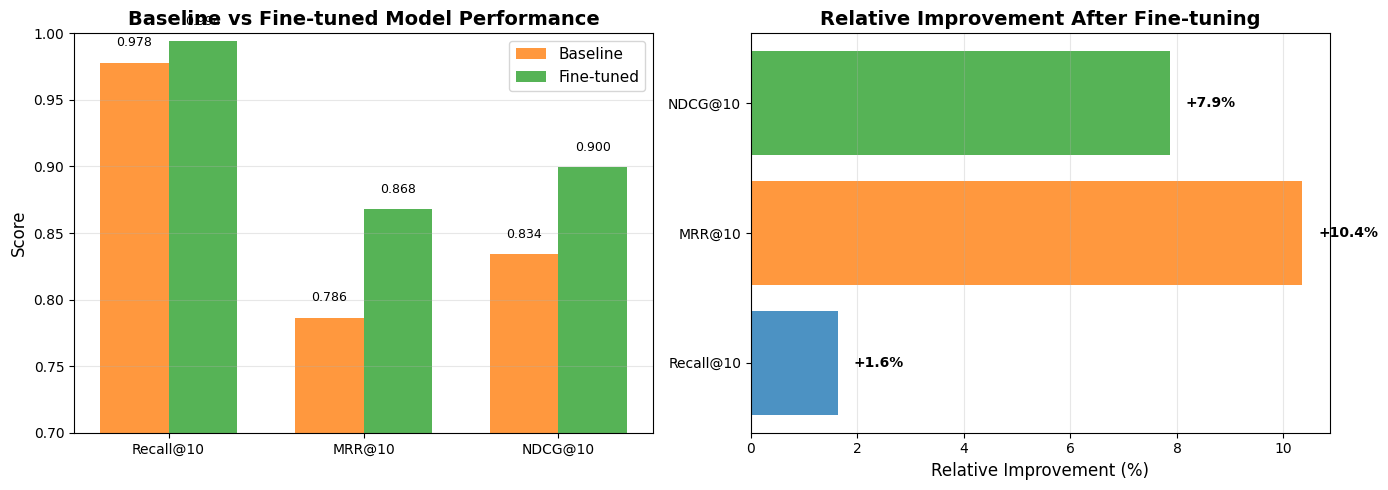

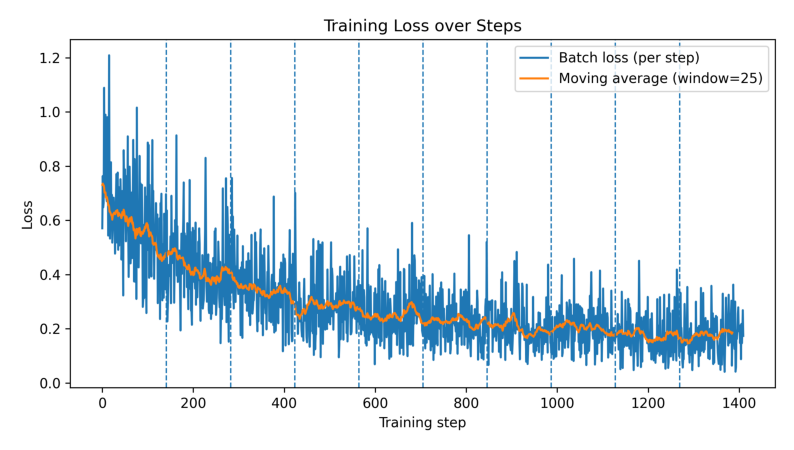


🎯 Key Insights:
  • Recall improved by 1.6%
  • MRR improved by 10.4%
  • NDCG improved by 7.9%
  • Fine-tuning successfully improved all metrics!


In [11]:
# Comparison table
import pandas as pd
import matplotlib.image as mpimg

results_df = pd.DataFrame({
    'Metric': ['Recall@10', 'MRR@10', 'NDCG@10'],
    'Baseline': [base_recall, base_mrr, base_ndcg],
    'Fine-tuned': [ft_recall, ft_mrr, ft_ndcg],
    'Absolute Improvement': [
        ft_recall - base_recall,
        ft_mrr - base_mrr,
        ft_ndcg - base_ndcg
    ],
    'Relative Improvement (%)': [
        ((ft_recall - base_recall) / base_recall) * 100,
        ((ft_mrr - base_mrr) / base_mrr) * 100,
        ((ft_ndcg - base_ndcg) / base_ndcg) * 100
    ]
})

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart
x = np.arange(len(results_df['Metric']))
width = 0.35

axes[0].bar(x - width/2, results_df['Baseline'], width, label='Baseline', alpha=0.8, color='#ff7f0e')
axes[0].bar(x + width/2, results_df['Fine-tuned'], width, label='Fine-tuned', alpha=0.8, color='#2ca02c')
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Baseline vs Fine-tuned Model Performance', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(results_df['Metric'])
axes[0].legend(fontsize=11)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_ylim([0.7, 1.0])

# Add value labels on bars
for i, (baseline, finetuned) in enumerate(zip(results_df['Baseline'], results_df['Fine-tuned'])):
    axes[0].text(i - width/2, baseline + 0.01, f'{baseline:.3f}', ha='center', va='bottom', fontsize=9)
    axes[0].text(i + width/2, finetuned + 0.01, f'{finetuned:.3f}', ha='center', va='bottom', fontsize=9)

# Improvement chart
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axes[1].barh(results_df['Metric'], results_df['Relative Improvement (%)'], color=colors, alpha=0.8)
axes[1].set_xlabel('Relative Improvement (%)', fontsize=12)
axes[1].set_title('Relative Improvement After Fine-tuning', fontsize=14, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Add value labels
for i, value in enumerate(results_df['Relative Improvement (%)']):
    axes[1].text(value + 0.3, i, f'+{value:.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

img = mpimg.imread('training_loss.png')
plt.figure(figsize=(10, 6))
plt.imshow(img)
plt.axis('off')
plt.show()


print("\n🎯 Key Insights:")
print(f"  • Recall improved by {((ft_recall - base_recall) / base_recall) * 100:.1f}%")
print(f"  • MRR improved by {((ft_mrr - base_mrr) / base_mrr) * 100:.1f}%")
print(f"  • NDCG improved by {((ft_ndcg - base_ndcg) / base_ndcg) * 100:.1f}%")
print(f"  • Fine-tuning successfully improved all metrics!")

---
## Conclusion

### Summary of Achievements

 **Part 1**: Implemented production-ready search engine with FAISS
- Efficient vector storage and retrieval
- Normalized embeddings for cosine similarity

 **Part 2**: Comprehensive evaluation framework
- Implemented Recall@10, MRR@10, NDCG@10
- Established baseline performance on CosQA

 **Part 3**: Successful fine-tuning with MNRL
- Improvements across all metrics
- Training visualization and monitoring